In [12]:

from sklearn.cluster import KMeans
from tensorflow.keras.datasets import mnist
import numpy as np
import sklearn
import tensorflow.keras as keras
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K

#----------------------------------
#clustering
def Clustering(data,ClusterNumber):
    # Runs in parallel 4 CPUs
    kmeans = KMeans(n_clusters=ClusterNumber, n_init=20, n_jobs=7)
    # Train K-Means.
    y_pred_kmeans = kmeans.fit_predict(data)
    # Evaluate the K-Means clustering accuracy.
    return kmeans,y_pred_kmeans
#----------------------------------
#PreProcessing    
def PreProcessing(data):
    data = np.divide(255)

#-----------------------------------
#AutoEncoder Model
def AutoEncoder(InputSize=784,encoding_dim=32):
    input_img = keras.layers.Input(shape=(InputSize,))
    encoded = keras.layers.Dense(encoding_dim, activation='relu')(input_img)
    decoded =  keras.layers.Dense(784, activation='sigmoid')(encoded)

    autoencoder = keras.Model(input_img, decoded)
    encoder = keras.Model(input_img, encoded)
    # create a placeholder for an encoded (32-dimensional) input
    encoded_input = keras.Input(shape=(encoding_dim,))
    # retrieve the last layer of the autoencoder model
    decoder_layer = autoencoder.layers[-1]
    # create the decoder model
    decoder = keras.Model(encoded_input, decoder_layer(encoded_input))
    autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy', metrics=['mse'])
    return autoencoder,encoder, decoder

#-----------------------------------
#AutoEncoder Model
def CNNAutoEncoder(InputSize=(28,28,1)):
    input_img = Input(shape=InputSize) 

    x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
    encoded = MaxPooling2D((2, 2), padding='same')(x)

    # at this point the representation is (4, 4, 8) i.e. 128-dimensional
    decoder_input = Input(shape=(4, 4, 8,))
    x = Conv2D(8, (3, 3), activation='relu', padding='same')(decoder_input)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(16, (3, 3), activation='relu')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

    decoder = keras.Model(decoder_input,decoded)
    autoencoder = Model(input_img, decoder(encoded))
    encoder = keras.Model(input_img, encoded)
    
    #decoder_input = keras.Input(shape=(4,4,8,))
    #xx= autoencoder.layers[-7]
    #xx=xx(decoder_input)
    
    
    
    autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')
    
    
    return autoencoder,encoder, decoder
    

#-----------------------------------
# Cluster Visualizer
#This methos get a buch of Picture and visulize them
def Visulizer(Pictures):
    plt.figure(figsize=(20, 4))
    for i in range(Pictures.shape[0]):
        # display original
        ax = plt.subplot(1, 20,  i+1)
        plt.imshow(Pictures[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

In [2]:
#AutoEncoder Example
from tensorflow.keras.datasets import mnist

(x_train, _), (x_test, _) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print( x_test.shape)

autoencoder,encoder, decoder = AutoEncoder()
autoencoder.fit(x_train, x_train,
                epochs=5,
                batch_size=256,
                shuffle=True,
                validation_data=(x_train, x_train))
# encode and decode some digits

encoded_imgs = encoder.predict(x_train)
decoded_imgs = decoder.predict(encoded_imgs)


(60000, 784)
(10000, 784)
Train on 60000 samples, validate on 60000 samples
Epoch 1/5
60000/60000 [==============================] - 4s 64us/step - loss: 0.3557 - mean_squared_error: 0.0970 - val_loss: 0.2730 - val_mean_squared_error: 0.0691
Epoch 2/5
60000/60000 [==============================] - 3s 55us/step - loss: 0.2662 - mean_squared_error: 0.0668 - val_loss: 0.2576 - val_mean_squared_error: 0.0637
Epoch 3/5
60000/60000 [==============================] - 3s 54us/step - loss: 0.2462 - mean_squared_error: 0.0593 - val_loss: 0.2348 - val_mean_squared_error: 0.0551
Epoch 4/5
60000/60000 [==============================] - 4s 59us/step - loss: 0.2249 - mean_squared_error: 0.0517 - val_loss: 0.2158 - val_mean_squared_error: 0.0485
Epoch 5/5
60000/60000 [==============================] - 3s 53us/step - loss: 0.2085 - mean_squared_error: 0.0461 - val_loss: 0.2019 - val_mean_squared_error: 0.0439


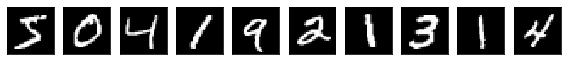

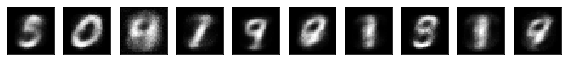

In [13]:
# Visualize the decoded and orginal of 10 first train data
Visulizer(x_train[:10])
Visulizer(decoded_imgs[:10])

In [14]:
#Clusterin
k_means,label = Clustering(encoded_imgs,10)

(6302, 784) (60000,)
[7 5 2 4 9 1 6 8 4 0 8 4 7 1 4 9 1 6 2 6]


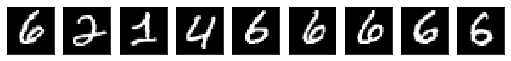

In [15]:
classONE = x_train[label == 1]
print(classONE.shape,label.shape)
print(label[:20])
Visulizer(classONE[1:10])


In [17]:
#CNN Example

from tensorflow.keras.datasets import mnist
import numpy as np

(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))  # adapt this if using `channels_first` image data format
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))  # adapt this if using `channels_first` image data format



from tensorflow.keras.callbacks import TensorBoard

autoencoder,encoder, decoder = CNNAutoEncoder()

autoencoder.fit(x_train, x_train,
                epochs=2,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test),
                callbacks=[TensorBoard(log_dir='/tmp/autoencoder')])
                

Train on 60000 samples, validate on 10000 samples
Epoch 1/2
60000/60000 [==============================] - 1799s 30ms/step - loss: 0.2019 - val_loss: 0.1575
Epoch 2/2
60000/60000 [==============================] - 1688s 28ms/step - loss: 0.1492 - val_loss: 0.1394


In [62]:
autoencoder.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_43 (InputLayer)        (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_168 (Conv2D)          (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d_72 (MaxPooling (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_169 (Conv2D)          (None, 14, 14, 8)         1160      
_________________________________________________________________
max_pooling2d_73 (MaxPooling (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_170 (Conv2D)          (None, 7, 7, 8)           584       
_________________________________________________________________
max_pooling2d_74 (MaxPooling (None, 4, 4, 8)           0         
__________

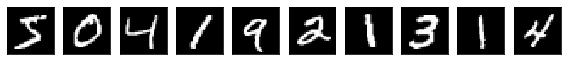

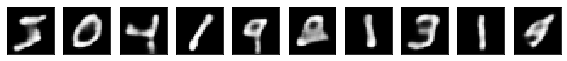

In [19]:
# encode and decode some digits

encoded_imgs = encoder.predict(x_train)
decoded_imgs = decoder.predict(encoded_imgs)
Visulizer(x_train[:10])
Visulizer(decoded_imgs[:10])

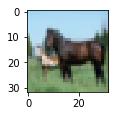

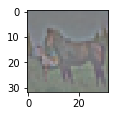

In [30]:
#----------------------------------------
# Zero Component analyze
#X is numpy array which containd all pictures
def ZCA(X):
    X = X.reshape(X.shape[0], X.shape[1]*X.shape[2]*X.shape[3])
    X_norm = X / 255.

    X_norm = X_norm - X_norm.mean(axis=0)
    X_norm.mean(axis=0)
    cov = np.cov(X_norm, rowvar=True)
    U,S,V = np.linalg.svd(cov)
    epsilon = 0.1
    X_ZCA = U.dot(np.diag(1.0/np.sqrt(S + epsilon))).dot(U.T).dot(X_norm)
    X_ZCA_rescaled = (X_ZCA - X_ZCA.min()) / (X_ZCA.max() - X_ZCA.min())
    return X_ZCA_rescaled

def plotImage(X):
    plt.figure(figsize=(1.5, 1.5))
    plt.imshow(X.reshape(32,32,3))
    plt.show()
    plt.close()
    






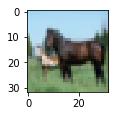

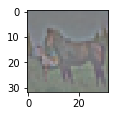

In [37]:
# Zero Component Analyze
(train, _), (_, _) = cifar10.load_data()
ZCA_rescaled = ZCA(train[0:10000])
plotImage(train[12, :])
plotImage(ZCA_rescaled[12, :])